In [127]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

1. Load Data

In [128]:
# load data
df = pd.read_csv('../../data/H2.csv')

2. Pre-Prepare the Data

In [129]:
# Handle missing values
df["Children"].fillna(0, inplace=True)  # Fill missing 'Children' with 0
df["Country"].fillna("Unknown", inplace=True)  # Fill missing 'Country' with 'Unknown'

# Drop rows where adults, babies and children are zero at the same time
df = df[(df["Adults"] != 0) | (df["Babies"] != 0) | (df["Children"] != 0)]

In [130]:
# Drop Duplicate rows
print(f"Total Number of Rows: {len(df)}")
print(f"Total Number of Rows without Duplicates: {len(df.drop_duplicates())}")

df = df.drop_duplicates()

Total Number of Rows: 79163
Total Number of Rows without Duplicates: 53274


In [131]:
# Remove Outliers
# Get only numerical data
df_num = df.select_dtypes(include=[np.number])
# Get only Categorical data
df_cat = df.select_dtypes(include=["object"])

df_num_out = df_num[["LeadTime", "ADR"]]

# Outlier Detection Fonksion
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Remove Outliers
def remove_outliers(data, outliers):
  return data.drop(outliers.index)

for col in df_num_out:
  outliers = detect_outliers_iqr(df, col)
  df = remove_outliers(df, outliers)
  print(f"{col}: {len(outliers)} outliers removed.")

df.shape

LeadTime: 702 outliers removed.
ADR: 566 outliers removed.


(52006, 31)

In [132]:
df.columns, df.shape

(Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
        'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
        'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
        'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
        'IsRepeatedGuest', 'PreviousCancellations',
        'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
        'BookingChanges', 'DepositType', 'Agent', 'Company',
        'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
        'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate'],
       dtype='object'),
 (52006, 31))

In [133]:
# Remove columns NOT useful for the model
df = df.drop(
    [
        "ReservationStatus",
        "AssignedRoomType",
        "ArrivalDateYear",
        "AssignedRoomType",
        "BookingChanges",
        "ArrivalDateYear",
        "ArrivalDateWeekNumber",
        "ArrivalDateDayOfMonth",
        "DaysInWaitingList",
        "Country",
    ],
    axis=1,
)

In [134]:
# Create Features from 'ReservationStatusDate' column
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])

df['Year'] = df['ReservationStatusDate'].dt.year
df['Month'] = df['ReservationStatusDate'].dt.month
df['Day'] = df['ReservationStatusDate'].dt.day

df.drop(['ReservationStatusDate'] , axis = 1, inplace = True)

In [135]:
# Correct the wrong type in 'Agent' and 'Company' columns

# Remove blank spaces
remove_spaces = lambda col: df[col].str.strip()

# Replace 'NULL' values with 0
replace_null = lambda col: df[col].replace("NULL", 0)

# Convert the column to integer
convert_to_int = lambda col: df[col].astype(int)


# Correct the 'Agent' column
df['Agent'] = remove_spaces('Agent')
df['Agent'] = replace_null('Agent')
df['Agent'] = convert_to_int('Agent')

# Correct the 'Company' column
df['Company'] = remove_spaces('Company')
df['Company'] = replace_null('Company')
df['Company'] = convert_to_int('Company')

In [136]:
# Remove rare categories
def remove_rare_categories(df, categorical_cols, min_count=10):
    """
    In categorical columns, it deletes categories that are below a certain threshold value.
        Args:
            df: Pandas DataFrame
            categorical_cols: List of categorical columns
            min_count: Minimum number of observations for a category to remain
    """

    for col in categorical_cols:
        value_counts = df[col].value_counts()
        common_categories = value_counts[value_counts >= min_count].index
        df = df[df[col].isin(common_categories)]
    return df


df = remove_rare_categories(
    df, df.select_dtypes(include=["object"]).columns, min_count=10
)

3. Feature Engineering Pipeline

In [137]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


# Custom transformers for feature engineering
def add_group_type(data):
    def determine_group_type(row):
        if row["Adults"] == 1 and (row["Children"] + row["Babies"] == 0):
            return "Single"
        elif row["Adults"] == 2 and (row["Children"] + row["Babies"] == 0):
            return "Couple"
        elif (row["Children"] + row["Babies"]) > 0:
            return "Family"
        elif row["Adults"] > 2:
            return "Big_Group"
        else:
            return "Other"

    data["GroupType"] = data.apply(determine_group_type, axis=1)
    return data


def add_booking_urgency(data):
    def determine_booking_urgency(lead_time):
        if lead_time > 60:
            return "Early_Booking"
        elif 30 <= lead_time <= 60:
            return "Medium_Term_Booking"
        else:
            return "Last_Minute_Booking"

    data["BookingUrgency"] = data["LeadTime"].apply(determine_booking_urgency)
    return data


def add_high_demand(data):
    data["HighDemand"] = data["TotalOfSpecialRequests"].apply(
        lambda x: "High" if x >= 2 else "Low"
    )
    return data


def add_child_ratio(data):
    data["ChildRatio"] = (data["Children"] + data["Babies"]) / (
        data["Adults"] + data["Children"] + data["Babies"]
    )
    data["ChildRatio"].fillna(0, inplace=True)
    return data


def add_total_guests(data):
    data["TotalGuests"] = data["Adults"] + data["Children"] + data["Babies"]
    return data


# Pipeline for feature engineering
feature_engineering_pipeline = Pipeline(
    steps=[
        ("add_group_type", FunctionTransformer(add_group_type)),
        ("add_booking_urgency", FunctionTransformer(add_booking_urgency)),
        ("add_high_demand", FunctionTransformer(add_high_demand)),
        ("add_child_ratio", FunctionTransformer(add_child_ratio)),
        ("add_total_guests", FunctionTransformer(add_total_guests)),
    ]
)

In [138]:
# Transform the data using feature engineering the pipeline 
feature_engineering_pipeline.fit(df)
df = feature_engineering_pipeline.transform(df)

In [139]:
df.head()

,IsCanceled,LeadTime,ArrivalDateMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,DepositType,Agent,Company,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,Year,Month,Day,GroupType,BookingUrgency,HighDemand,ChildRatio,TotalGuests
0,0,6,July,0,2,1,0.0,0,HB,Offline TA/TO,TA/TO,0,0,0,A,No Deposit,6,0,Transient,0.0,0,0,2015,7,3,Single,Last_Minute_Booking,Low,0.0,1.0
1,1,88,July,0,4,2,0.0,0,BB,Online TA,TA/TO,0,0,0,A,No Deposit,9,0,Transient,76.5,0,1,2015,7,1,Couple,Early_Booking,Low,0.0,2.0
2,1,65,July,0,4,1,0.0,0,BB,Online TA,TA/TO,0,0,0,A,No Deposit,9,0,Transient,68.0,0,1,2015,4,30,Single,Early_Booking,Low,0.0,1.0
3,1,92,July,2,4,2,0.0,0,BB,Online TA,TA/TO,0,0,0,A,No Deposit,9,0,Transient,76.5,0,2,2015,6,23,Couple,Early_Booking,High,0.0,2.0
4,1,100,July,0,2,2,0.0,0,BB,Online TA,TA/TO,0,0,0,A,No Deposit,9,0,Transient,76.5,0,1,2015,4,2,Couple,Early_Booking,Low,0.0,2.0


4. Split the Data to X and y

In [140]:
# Split data to features and target
X = df.drop("IsCanceled", axis=1)
y = df["IsCanceled"]

5. Preprocessor Pipeline

In [141]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer


# Categoric and Numeric features
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns

# Preprocessing for numerical data
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Preprocessing for categorical data
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

6. SMOTE

In [142]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Define the pipeline with SMOTE and preprocessor
smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42))
])

# Fit and transform the training data
X, y = smote_pipeline.fit_resample(X, y)

# Check the resulting class distribution after SMOTE
print(f"Class distribution before SMOTE: {y.value_counts(normalize=True)}")
print(f"Class distribution after SMOTE: {y.value_counts(normalize=True)}")

Class distribution before SMOTE: IsCanceled
0    0.5
1    0.5
Name: proportion, dtype: float64
Class distribution after SMOTE: IsCanceled
0    0.5
1    0.5
Name: proportion, dtype: float64


In [143]:
# type(X_train_res), type(y_train_res), type(X_test), type(y_test)
type(X), type(y)

(numpy.ndarray, pandas.core.series.Series)

In [144]:
# Convert X_train_res to a DataFrame
# X_train_res = pd.DataFrame(X_train_res, columns=preprocessor.get_feature_names_out())
# X_train_res.head()
X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())
X.head()

,num__LeadTime,num__StaysInWeekendNights,num__StaysInWeekNights,num__Adults,num__Children,num__Babies,num__IsRepeatedGuest,num__PreviousCancellations,num__PreviousBookingsNotCanceled,num__Agent,num__Company,num__ADR,num__RequiredCarParkingSpaces,num__TotalOfSpecialRequests,num__ChildRatio,num__TotalGuests,cat__ArrivalDateMonth_April,cat__ArrivalDateMonth_August,cat__ArrivalDateMonth_December,cat__ArrivalDateMonth_February,cat__ArrivalDateMonth_January,cat__ArrivalDateMonth_July,cat__ArrivalDateMonth_June,cat__ArrivalDateMonth_March,cat__ArrivalDateMonth_May,cat__ArrivalDateMonth_November,cat__ArrivalDateMonth_October,cat__ArrivalDateMonth_September,cat__Meal_BB,cat__Meal_FB,cat__Meal_HB,cat__Meal_SC,cat__MarketSegment_Aviation,cat__MarketSegment_Complementary,cat__MarketSegment_Corporate,cat__MarketSegment_Direct,cat__MarketSegment_Groups,cat__MarketSegment_Offline TA/TO,cat__MarketSegment_Online TA,cat__DistributionChannel_Corporate,cat__DistributionChannel_Direct,cat__DistributionChannel_GDS,cat__DistributionChannel_TA/TO,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__DepositType_No Deposit,cat__DepositType_Non Refund,cat__DepositType_Refundable,cat__CustomerType_Contract,cat__CustomerType_Group,cat__CustomerType_Transient,cat__CustomerType_Transient-Party,cat__GroupType_Big_Group,cat__GroupType_Couple,cat__GroupType_Family,cat__GroupType_Single,cat__BookingUrgency_Early_Booking,cat__BookingUrgency_Last_Minute_Booking,cat__BookingUrgency_Medium_Term_Booking,cat__HighDemand_High,cat__HighDemand_Low
0,-0.921221,-0.966242,-0.171276,-1.645001,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.319919,-0.178752,-2.810717,-0.191045,-0.855834,-0.299154,-1.490205,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.193789,-0.966242,1.084781,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,-0.852430,-0.191045,0.343861,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.118958,-0.966242,1.084781,-1.645001,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,-1.070017,-0.191045,0.343861,-0.299154,-1.490205,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.248180,1.244291,1.084781,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,-0.852430,-0.191045,1.543556,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.356961,-0.966242,-0.171276,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,-0.852430,-0.191045,0.343861,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [145]:
# X_train_res.shape, y_train_res.shape, X_test.shape, y_test.shape
X.shape, y.shape

((73116, 66), (73116,))

7. Add Customer Segmentation to the Data

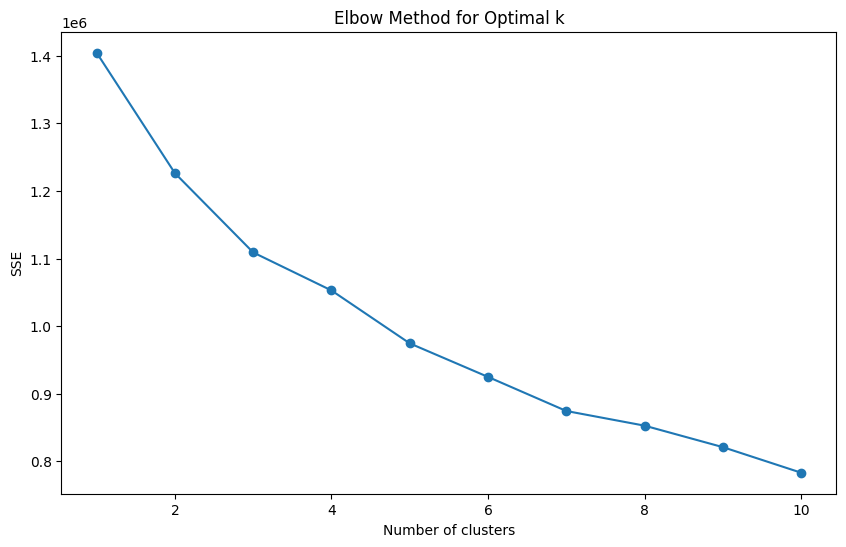

In [146]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

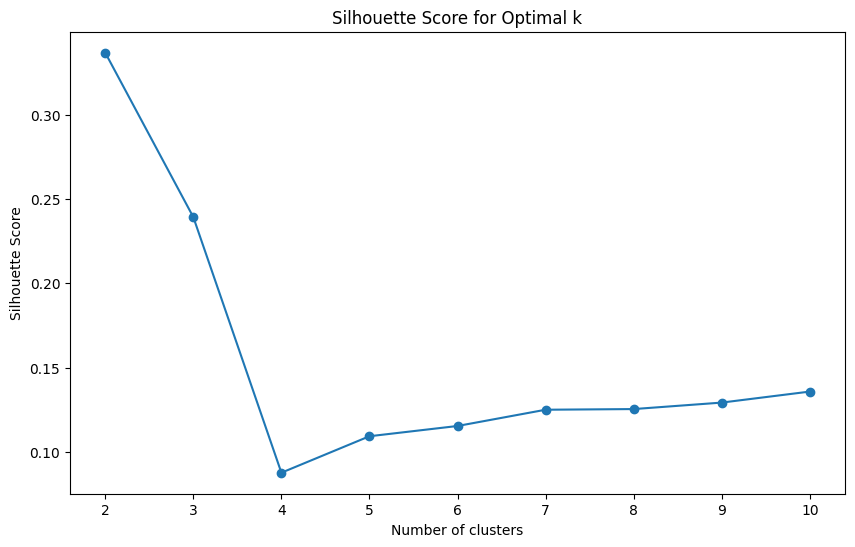

In [147]:
# Silhouette Score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


In [149]:
# Create KMeans model with k=7
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X)

# Predict the clusters
clusters = kmeans.predict(X)

# Add the cluster labels to the dataframe
X['Cluster'] = clusters

X.head()

,num__LeadTime,num__StaysInWeekendNights,num__StaysInWeekNights,num__Adults,num__Children,num__Babies,num__IsRepeatedGuest,num__PreviousCancellations,num__PreviousBookingsNotCanceled,num__Agent,num__Company,num__ADR,num__RequiredCarParkingSpaces,num__TotalOfSpecialRequests,num__ChildRatio,num__TotalGuests,cat__ArrivalDateMonth_April,cat__ArrivalDateMonth_August,cat__ArrivalDateMonth_December,cat__ArrivalDateMonth_February,cat__ArrivalDateMonth_January,cat__ArrivalDateMonth_July,cat__ArrivalDateMonth_June,cat__ArrivalDateMonth_March,cat__ArrivalDateMonth_May,cat__ArrivalDateMonth_November,cat__ArrivalDateMonth_October,cat__ArrivalDateMonth_September,cat__Meal_BB,cat__Meal_FB,cat__Meal_HB,cat__Meal_SC,cat__MarketSegment_Aviation,cat__MarketSegment_Complementary,cat__MarketSegment_Corporate,cat__MarketSegment_Direct,cat__MarketSegment_Groups,cat__MarketSegment_Offline TA/TO,cat__MarketSegment_Online TA,cat__DistributionChannel_Corporate,cat__DistributionChannel_Direct,cat__DistributionChannel_GDS,cat__DistributionChannel_TA/TO,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__DepositType_No Deposit,cat__DepositType_Non Refund,cat__DepositType_Refundable,cat__CustomerType_Contract,cat__CustomerType_Group,cat__CustomerType_Transient,cat__CustomerType_Transient-Party,cat__GroupType_Big_Group,cat__GroupType_Couple,cat__GroupType_Family,cat__GroupType_Single,cat__BookingUrgency_Early_Booking,cat__BookingUrgency_Last_Minute_Booking,cat__BookingUrgency_Medium_Term_Booking,cat__HighDemand_High,cat__HighDemand_Low,Cluster
0,-0.921221,-0.966242,-0.171276,-1.645001,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.319919,-0.178752,-2.810717,-0.191045,-0.855834,-0.299154,-1.490205,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,3
1,0.193789,-0.966242,1.084781,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,-0.852430,-0.191045,0.343861,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2
2,-0.118958,-0.966242,1.084781,-1.645001,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,-1.070017,-0.191045,0.343861,-0.299154,-1.490205,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3
3,0.248180,1.244291,1.084781,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,-0.852430,-0.191045,1.543556,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,6
4,0.356961,-0.966242,-0.171276,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,-0.852430,-0.191045,0.343861,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2


8. Split the Data to the train, test split

In [150]:
from sklearn.model_selection import train_test_split

# TEST
# Stratified splitting into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

# Check the resulting split sizes and class distribution in both sets
train_size = X_train.shape[0]
test_size = X_test.shape[0]
train_class_distribution = y_train.value_counts(normalize=True)
test_class_distribution = y_test.value_counts(normalize=True)

train_size, test_size, train_class_distribution, test_class_distribution

(58492,
 14624,
 IsCanceled
 1    0.5
 0    0.5
 Name: proportion, dtype: float64,
 IsCanceled
 1    0.5
 0    0.5
 Name: proportion, dtype: float64)

In [151]:
X_train.head()

,num__LeadTime,num__StaysInWeekendNights,num__StaysInWeekNights,num__Adults,num__Children,num__Babies,num__IsRepeatedGuest,num__PreviousCancellations,num__PreviousBookingsNotCanceled,num__Agent,num__Company,num__ADR,num__RequiredCarParkingSpaces,num__TotalOfSpecialRequests,num__ChildRatio,num__TotalGuests,cat__ArrivalDateMonth_April,cat__ArrivalDateMonth_August,cat__ArrivalDateMonth_December,cat__ArrivalDateMonth_February,cat__ArrivalDateMonth_January,cat__ArrivalDateMonth_July,cat__ArrivalDateMonth_June,cat__ArrivalDateMonth_March,cat__ArrivalDateMonth_May,cat__ArrivalDateMonth_November,cat__ArrivalDateMonth_October,cat__ArrivalDateMonth_September,cat__Meal_BB,cat__Meal_FB,cat__Meal_HB,cat__Meal_SC,cat__MarketSegment_Aviation,cat__MarketSegment_Complementary,cat__MarketSegment_Corporate,cat__MarketSegment_Direct,cat__MarketSegment_Groups,cat__MarketSegment_Offline TA/TO,cat__MarketSegment_Online TA,cat__DistributionChannel_Corporate,cat__DistributionChannel_Direct,cat__DistributionChannel_GDS,cat__DistributionChannel_TA/TO,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__DepositType_No Deposit,cat__DepositType_Non Refund,cat__DepositType_Refundable,cat__CustomerType_Contract,cat__CustomerType_Group,cat__CustomerType_Transient,cat__CustomerType_Transient-Party,cat__GroupType_Big_Group,cat__GroupType_Couple,cat__GroupType_Family,cat__GroupType_Single,cat__BookingUrgency_Early_Booking,cat__BookingUrgency_Last_Minute_Booking,cat__BookingUrgency_Medium_Term_Booking,cat__HighDemand_High,cat__HighDemand_Low,Cluster
71151,0.688215,1.244291,-0.171276,0.225371,4.495176,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,2.553343,-0.191045,0.343861,3.481372,2.946792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053247,0.946753,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,4
4909,-0.064567,-0.966242,1.084781,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,-0.700119,-0.191045,-0.855834,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2
4275,-0.350119,0.139024,0.456752,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,-0.917706,-0.191045,0.343861,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
30427,-0.703658,1.244291,-0.799305,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,2.726844,-0.178752,-0.634842,-0.191045,-0.855834,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
59083,0.611200,-0.966242,0.814481,2.095743,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,1.793818,-0.191045,0.343861,-0.299154,1.467793,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1


In [152]:
X_test.head()

,num__LeadTime,num__StaysInWeekendNights,num__StaysInWeekNights,num__Adults,num__Children,num__Babies,num__IsRepeatedGuest,num__PreviousCancellations,num__PreviousBookingsNotCanceled,num__Agent,num__Company,num__ADR,num__RequiredCarParkingSpaces,num__TotalOfSpecialRequests,num__ChildRatio,num__TotalGuests,cat__ArrivalDateMonth_April,cat__ArrivalDateMonth_August,cat__ArrivalDateMonth_December,cat__ArrivalDateMonth_February,cat__ArrivalDateMonth_January,cat__ArrivalDateMonth_July,cat__ArrivalDateMonth_June,cat__ArrivalDateMonth_March,cat__ArrivalDateMonth_May,cat__ArrivalDateMonth_November,cat__ArrivalDateMonth_October,cat__ArrivalDateMonth_September,cat__Meal_BB,cat__Meal_FB,cat__Meal_HB,cat__Meal_SC,cat__MarketSegment_Aviation,cat__MarketSegment_Complementary,cat__MarketSegment_Corporate,cat__MarketSegment_Direct,cat__MarketSegment_Groups,cat__MarketSegment_Offline TA/TO,cat__MarketSegment_Online TA,cat__DistributionChannel_Corporate,cat__DistributionChannel_Direct,cat__DistributionChannel_GDS,cat__DistributionChannel_TA/TO,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__DepositType_No Deposit,cat__DepositType_Non Refund,cat__DepositType_Refundable,cat__CustomerType_Contract,cat__CustomerType_Group,cat__CustomerType_Transient,cat__CustomerType_Transient-Party,cat__GroupType_Big_Group,cat__GroupType_Couple,cat__GroupType_Family,cat__GroupType_Single,cat__BookingUrgency_Early_Booking,cat__BookingUrgency_Last_Minute_Booking,cat__BookingUrgency_Medium_Term_Booking,cat__HighDemand_High,cat__HighDemand_Low,Cluster
72729,-0.730854,-0.966242,-0.171276,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,0.344724,-0.191045,0.343861,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
50510,1.118431,-0.966242,0.456752,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,3.419290,-0.178752,-0.529889,-0.191045,-0.855834,-0.299154,-0.011206,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2
69691,0.034019,1.244291,-1.427333,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.036387,-0.178752,-0.689587,-0.191045,-0.855834,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.488627,0.511373,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
29435,-0.268532,0.139024,0.456752,0.225371,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,-0.250674,-0.178752,0.092155,-0.191045,0.343861,-0.299154,-0.011206,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
57344,0.897415,-0.966242,-0.729988,-1.645001,-0.289019,-0.070734,-0.181193,-0.093962,-0.094977,0.231490,-0.178752,0.303486,-0.191045,-0.855834,-0.299154,-1.490205,0.0,0.0,0.0,0.0,0.0,0.0,0.889628,0.0,0.0,0.0,0.0,0.110372,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3


In [153]:
X_train.shape, X_test.shape

((58492, 67), (14624, 67))

9. Train Models

1. Logistic Regression
2. Random Forest
3. Gradient Boosting
4. K-Nearest Neighbors
5. LightGBM
6. AdaBoost

--- Logistic Regression ---
Accuracy: 0.7129

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      7312
           1       0.71      0.72      0.72      7312

    accuracy                           0.71     14624
   macro avg       0.71      0.71      0.71     14624
weighted avg       0.71      0.71      0.71     14624



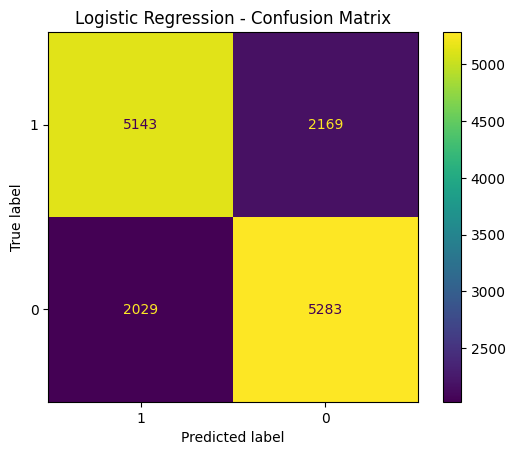

ROC AUC Score: 0.7877


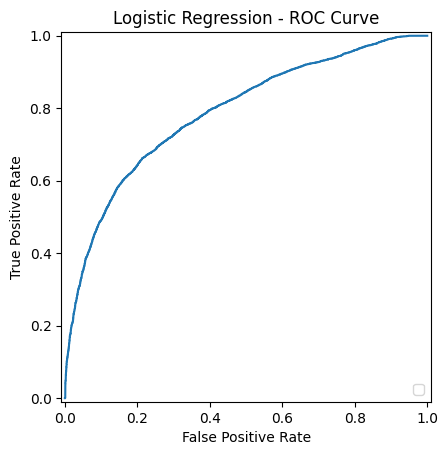



--- Random Forest ---
Accuracy: 0.8515

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      7312
           1       0.86      0.84      0.85      7312

    accuracy                           0.85     14624
   macro avg       0.85      0.85      0.85     14624
weighted avg       0.85      0.85      0.85     14624



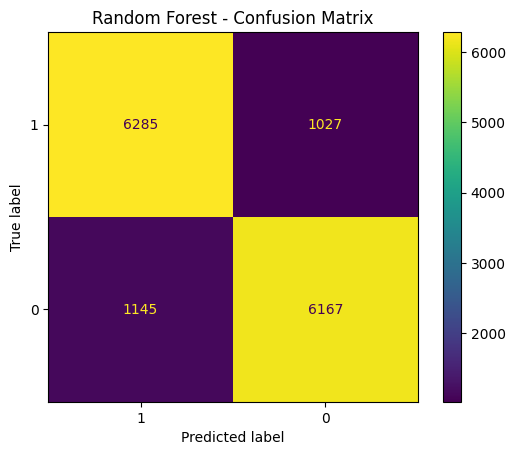

ROC AUC Score: 0.9199


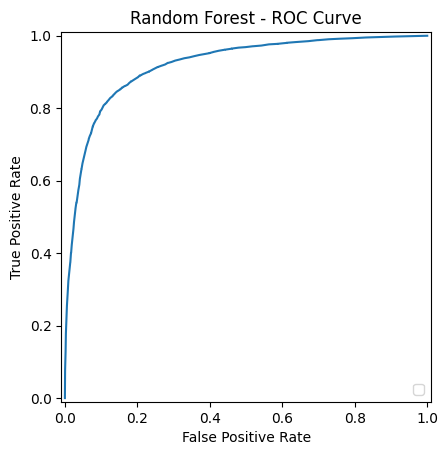



--- Gradient Boosting ---
Accuracy: 0.8102

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      7312
           1       0.84      0.76      0.80      7312

    accuracy                           0.81     14624
   macro avg       0.81      0.81      0.81     14624
weighted avg       0.81      0.81      0.81     14624



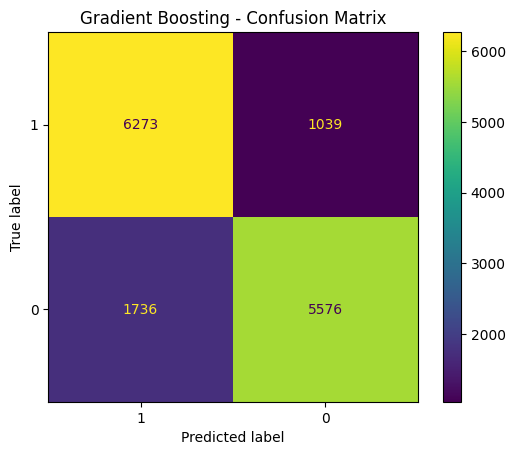

ROC AUC Score: 0.8845


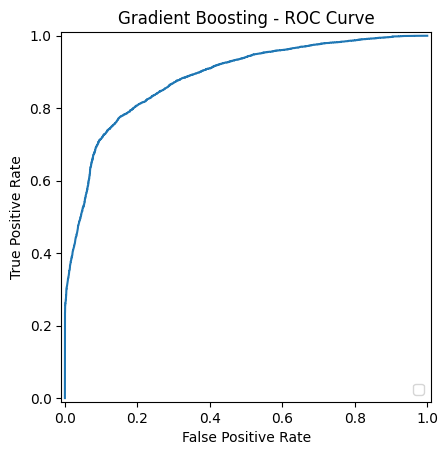



--- K-Nearest Neighbors ---
Accuracy: 0.7746

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      7312
           1       0.74      0.85      0.79      7312

    accuracy                           0.77     14624
   macro avg       0.78      0.77      0.77     14624
weighted avg       0.78      0.77      0.77     14624



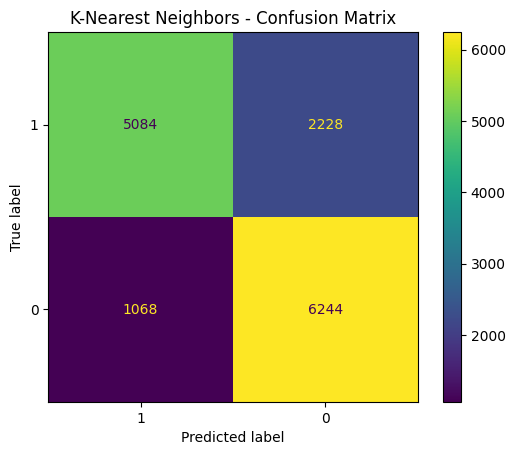

ROC AUC Score: 0.8499


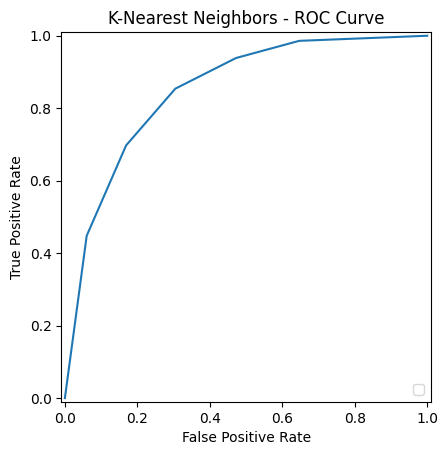



--- LightGBM ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 29246, number of negative: 29246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8954
[LightGBM] [Info] Number of data points in the train set: 58492, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.8389

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      7312
           1       0.87      0.79      0.83      7312

    accuracy                           0.84     14624
   macro avg       0.84      0.84      0.84     14624
weighted avg       0.84      0.84      0.84     14624



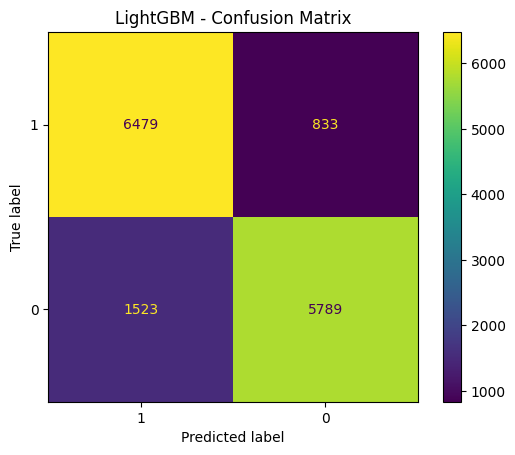

ROC AUC Score: 0.9153


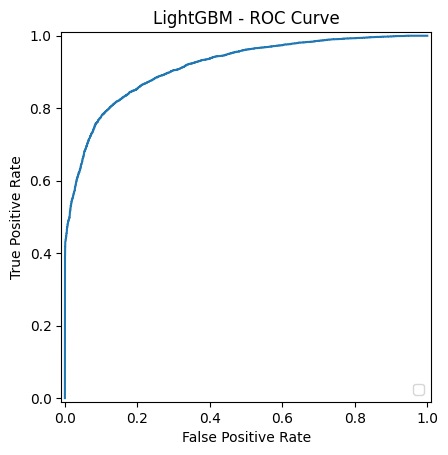



--- AdaBoost ---
Accuracy: 0.7315

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      7312
           1       0.71      0.78      0.74      7312

    accuracy                           0.73     14624
   macro avg       0.73      0.73      0.73     14624
weighted avg       0.73      0.73      0.73     14624



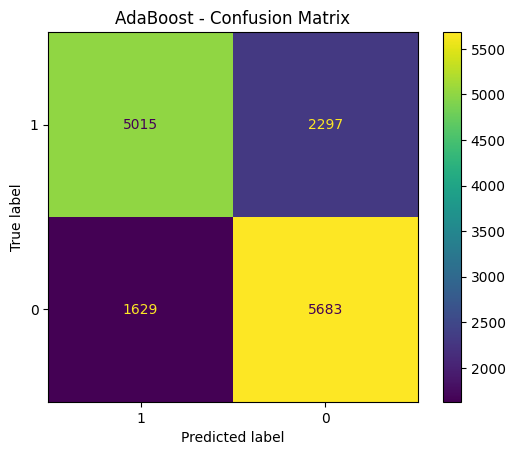

ROC AUC Score: 0.8059


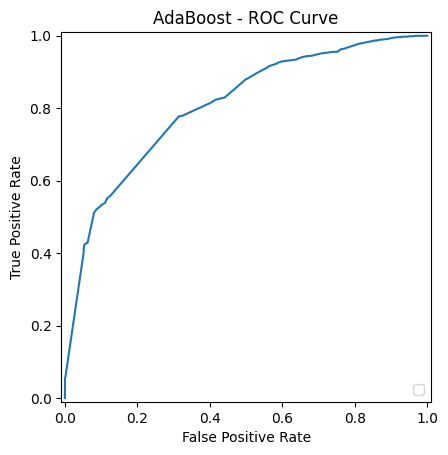

In [175]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

# Modellerin tanımlandığı bir liste
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("LightGBM", lgb.LGBMClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
]

# Train and evaluate models
for model_name, model in models:
    print(f"--- {model_name} ---")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Calculate Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
    disp.plot()
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # ROC AUC ve ROC Curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None

    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"ROC AUC Score: {roc_auc:.4f}")

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_disp.plot()
        plt.title(f"{model_name} - ROC Curve")
        plt.show()
    else:
        print("ROC AUC could not calculated.")
    print("\n")